<a href="https://colab.research.google.com/github/Adlucent/ga4-churn-prediction/blob/main/I_i_EDA_RFM_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I.i. EDA - RFM Customer Segmentation

When analyzing customer-level data, an RFM Customer Analysis is an important part of the EDA process. 

In this context, RFM stands for:<br>

* **R = Recency** (number of days since each customer's last order)
* **F = Frequency** (total number of orders within each customer's lifetime)
* **M = Monetary Value** (total lifetime value / revenue from each customer)

An RFM analysis helps us better understand the macro-level purchasing behavior of customers represented in the dataset by creating four segments within each of the R, F and M buckets. 

# Import Libraries

In [1]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'adl-analytics' #add proj name
region = "US"  # GCP project region

In [2]:
# Google credentials 
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics 
'''BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI '''

from google.cloud import bigquery
from google.cloud.bigquery import magics, Client, QueryJobConfig

magics.context.project = project_name
client = bigquery.Client(project=magics.context.project)

# data processing libraries
import pandas as pd
import numpy as np
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# suppress notebook warnings
import warnings
warnings.filterwarnings('ignore')

# dataframe display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Import data from BigQuery
Here we'll load the columns needed for an RFM analysis for records where `event_name` = "purchase."

In [3]:
%%bigquery data --project $project_name
SELECT user_pseudo_id, event_date, ecommerce
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE event_name = "purchase"

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
# make a copy of the dataframe to avoid re-importing if we need to revert back to the original dataset
df = data.copy()

# Data Preparation

In [5]:
  # unnest values in the ecommerce column
  df = pd.concat([df, df["ecommerce"].apply(pd.Series)], axis=1)
  df.drop(columns="ecommerce", axis=1, inplace=True)

In [6]:
# convert event_date to datetime data type
df["event_date"] = pd.to_datetime(df["event_date"])

Below, we'll set a cutoff date to divide the table into two pieces: 1) the pre-cutoff rows, and 2) the post-cutoff rows. Moving forward, we'll only perform analysis on the pre-cutoff table since the post-cutoff section will be used to define the churn target in a later notebook.

In [7]:
cutoff_date = df["event_date"].max() - timedelta(days=28)
print(cutoff_date)

2021-01-03 00:00:00


In [8]:
# separate the post-cutoff rows into a new table
df_post_cutoff = pd.DataFrame(df.loc[df["event_date"] >= cutoff_date])
df = pd.DataFrame(df.loc[df["event_date"] < cutoff_date])

## From the pre-cutoff table, select columns needed to calculate Recency, Frequency and Monetary Value Segments

In [9]:
df_rfm = df[
    [
        "transaction_id",
        "user_pseudo_id",
        "event_date",
        "purchase_revenue_in_usd",
    ]
].copy()

In [10]:
# drop any duplicate rows
df_rfm.drop_duplicates(subset=None, keep="first", inplace=True)

In [11]:
# check for null values
df_rfm.isna().sum()

transaction_id             22
user_pseudo_id              0
event_date                  0
purchase_revenue_in_usd     0
dtype: int64

There are some null values in `transaction_id`, but simce they are labeled as purchases, we'll just impute those null values with "not provided". 

In [12]:
df_rfm["transaction_id"] = df_rfm["transaction_id"].fillna("not provided")
df_rfm["transaction_id"] = df_rfm["transaction_id"].str.replace(
    "(not set)", "not provided"
)

In [13]:
# check one more time to make sure all null values are treated
df_rfm.isna().sum()

transaction_id             0
user_pseudo_id             0
event_date                 0
purchase_revenue_in_usd    0
dtype: int64

Set a snapshot date as one day after the last date in the pre-cutoff dataframe. This is to simulate a real life prediction scenario where we'd be making predictions on a snapshot date one day after the data cutoff. 

In [14]:
snapshot_date = df_rfm["event_date"].max() + timedelta(days=1)
print(snapshot_date)

2021-01-03 00:00:00


Since we're calculating R, F and M per customer, the next step is to group the table by user and aggregate the number of orders and total revenue.

In [15]:
# Group the datby user id
df_rfm = df_rfm.groupby(["user_pseudo_id"]).agg(
    {
        "event_date": lambda x: (snapshot_date - x.max()).days,
        "transaction_id": "count",
        "purchase_revenue_in_usd": "sum",
    }
)

In [16]:
# rename columns to Recency, Frequency, and MonetaryValue
df_rfm.rename(
    columns={
        "event_date": "Recency",
        "transaction_id": "Frequency",
        "purchase_revenue_in_usd": "MonetaryValue",
    },
    inplace=True,
)

In [17]:
print(df_rfm.head())
print("{:,} rows; {:,} columns".format(df_rfm.shape[0], df_rfm.shape[1]))

                     Recency  Frequency  MonetaryValue
user_pseudo_id                                        
10111055.8768683862       24          1         94.000
1014825.0200289249        61          1        183.000
1016446.8237887674        13          1         86.000
10172849.5375293351       25          1        156.000
1019527.5799124267        29          1         44.000
3,435 rows; 3 columns


Next, we'll plot the distributions of those three metrics to get a quick understanding them.

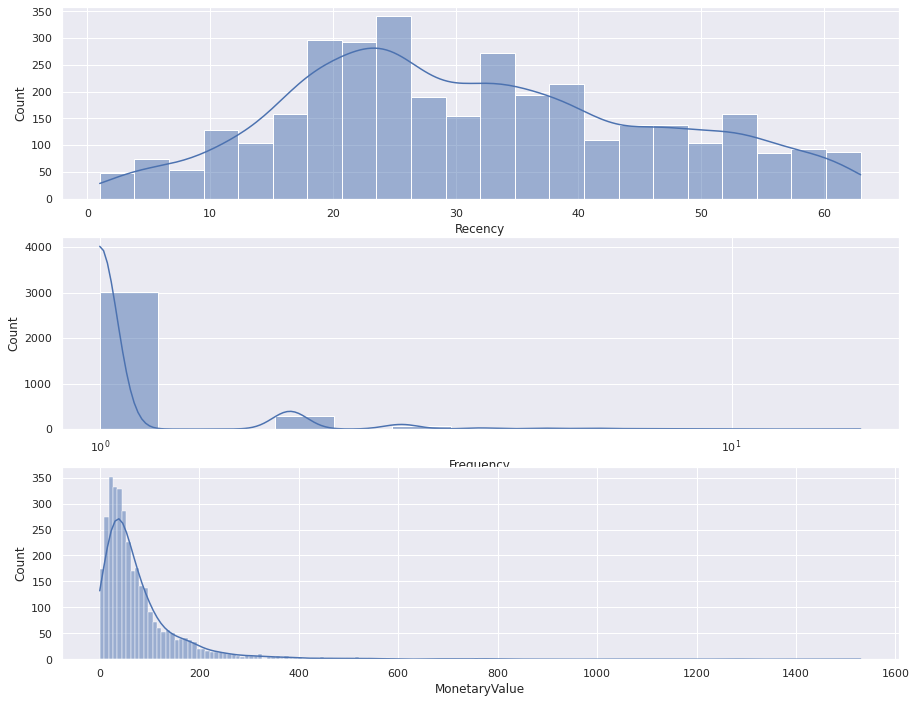

In [18]:
# Plot RFM distributions
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
sns.histplot(df_rfm["Recency"], kde=True)

plt.subplot(3, 1, 2)
sns.histplot(df_rfm["Frequency"], kde=True, log_scale=True)

plt.subplot(3, 1, 3)
sns.histplot(df_rfm["MonetaryValue"], kde=True)

plt.show()

From the plots above, we observe that users' last purchases range from 1 to more than 60 days ago as of the snapshot date. We also know that most customers in this dataset have only purchased one time, and have a MonetaryValue betwen 0.00 and 200.00.

Next, we'll create the R, F and M segments by dividing each metric into 4 quartiles, and create RFM Segments (concat of R, F and M) and RFM Scores (sum of R, F and M).

In [19]:
# recency quartiles
r_labels = range(4, 0, -1)
recency = df_rfm["Recency"]
r_quartiles, bins = pd.qcut(recency, 4, labels=r_labels, retbins=True)

# frequency quartiles
f_labels = range(1, 5)
frequency = df_rfm["Frequency"].rank(
    method="first"
)  # rank first to deal with duplicate values
f_quartiles, bins = pd.qcut(frequency, 4, labels=f_labels, retbins=True)

# monetary value quartiles
m_labels = range(1, 5)
monetary = df_rfm["MonetaryValue"]
m_quartiles, bins = pd.qcut(monetary, 4, labels=m_labels, retbins=True)

df_rfm = df_rfm.assign(R=r_quartiles.values, F=f_quartiles.values, M=m_quartiles.values)

In [20]:
# Create RFM segments and scores
def join_rfm(x):
    return str(x["R"]) + "." + str(x["F"]) + "." + str(x["M"])

df_rfm["rfmSegment"] = df_rfm.apply(join_rfm, axis=1)
df_rfm["rfmScore"] = df_rfm[["R", "F", "M"]].sum(axis=1)

df_rfm.sample(5)

,Recency,Frequency,MonetaryValue,R,F,M,rfmSegment,rfmScore
user_pseudo_id,,,,,,,,
70092642.2710325772,25,2,49.000,3,4,2,3.0.4.0.2.0,9
2865598.3084956057,23,1,48.000,3,1,2,3.0.1.0.2.0,6
57062019.1930840950,46,1,104.000,1,3,4,1.0.3.0.4.0,8
75317932.0666442596,55,1,3.000,1,3,1,1.0.3.0.1.0,5
12381181.9705732116,38,1,32.000,2,1,2,2.0.1.0.2.0,5


Next, to allow for reporting in how these labels change over time, we'll add a column showing the RFM Snapshot date, as well as a timestamp column to the table. 

In [21]:
df_rfm["rfmSnapshotDate"] = pd.to_datetime(snapshot_date)
df_rfm["TimeStamp"] = pd.to_datetime("now")
df_rfm.reset_index(drop=False, inplace=True)

Finally, inspect the table one more time before saving to BigQuery.

In [22]:
df_rfm.head()

,user_pseudo_id,Recency,Frequency,MonetaryValue,R,F,M,rfmSegment,rfmScore,rfmSnapshotDate,TimeStamp
0,10111055.8768683862,24,1,94.000,3,1,3,3.0.1.0.3.0,7,2021-01-03,2022-11-28 21:07:56.704541
1,1014825.0200289249,61,1,183.000,1,1,4,1.0.1.0.4.0,6,2021-01-03,2022-11-28 21:07:56.704541
2,1016446.8237887674,13,1,86.000,4,1,3,4.0.1.0.3.0,8,2021-01-03,2022-11-28 21:07:56.704541
3,10172849.5375293351,25,1,156.000,3,1,4,3.0.1.0.4.0,8,2021-01-03,2022-11-28 21:07:56.704541
4,1019527.5799124267,29,1,44.000,3,1,2,3.0.1.0.2.0,6,2021-01-03,2022-11-28 21:07:56.704541


In [23]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_pseudo_id   3435 non-null   object        
 1   Recency          3435 non-null   int64         
 2   Frequency        3435 non-null   int64         
 3   MonetaryValue    3435 non-null   float64       
 4   R                3435 non-null   category      
 5   F                3435 non-null   category      
 6   M                3435 non-null   category      
 7   rfmSegment       3435 non-null   object        
 8   rfmScore         3435 non-null   int64         
 9   rfmSnapshotDate  3435 non-null   datetime64[ns]
 10  TimeStamp        3435 non-null   datetime64[ns]
dtypes: category(3), datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 225.3+ KB


In [24]:
df_rfm["rfmScore"].value_counts()

7     615
8     590
6     531
9     477
5     343
10    301
11    210
4     193
12    109
3      66
Name: rfmScore, dtype: int64

In [26]:
client = bigquery.Client(project = project_name)
table_id = 'public_sample_data.churn_ga4_rfm' # #update with your dataset and table name

job_config = bigquery.LoadJobConfig(
    write_disposition = bigquery.job.WriteDisposition.WRITE_TRUNCATE
)

job = client.load_table_from_dataframe(
    df_rfm, table_id, job_config = job_config
)

# Wait for the load job to complete.
job.result()

LoadJob<project=adl-analytics, location=US, id=bf555f38-421c-40af-a2cc-a4fbd27c8304>